In [2]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import xml.etree.ElementTree as ET
import cv2

import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [4]:
tf.__version__

'2.7.0'

In [5]:
tf.get_logger().setLevel('ERROR')

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
BASE_PATH = "/content/images"
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1

In [8]:
BATCH_SIZE = 32
EPOCHS = 35
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

In [9]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(BASE_PATH, '*.jpg'))]

print(f"\nTotal number of image files: {len(imageNames)}")


Total number of image files: 7390


In [10]:
labels = [' '.join(name.split('_')[:-1]) for name in imageNames ]

print(f"\nTotal number of unique labels: {len(np.unique(labels))}")


Total number of unique labels: 37


In [11]:
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
for k, v in labelEncDict.items():
    print(f"{k:32} : {v}")

Abyssinian                       : 0
Bengal                           : 1
Birman                           : 2
Bombay                           : 3
British Shorthair                : 4
Egyptian Mau                     : 5
Maine Coon                       : 6
Persian                          : 7
Ragdoll                          : 8
Russian Blue                     : 9
Siamese                          : 10
Sphynx                           : 11
american bulldog                 : 12
american pit bull terrier        : 13
basset hound                     : 14
beagle                           : 15
boxer                            : 16
chihuahua                        : 17
english cocker spaniel           : 18
english setter                   : 19
german shorthaired               : 20
great pyrenees                   : 21
havanese                         : 22
japanese chin                    : 23
keeshond                         : 24
leonberger                       : 25
miniature pinscher    

In [12]:
labelDecDict = {ind: name for name, ind in labelEncDict.items()}
for k, v in labelDecDict.items():
    print(f"{k:3} : {v}")

  0 : Abyssinian
  1 : Bengal
  2 : Birman
  3 : Bombay
  4 : British Shorthair
  5 : Egyptian Mau
  6 : Maine Coon
  7 : Persian
  8 : Ragdoll
  9 : Russian Blue
 10 : Siamese
 11 : Sphynx
 12 : american bulldog
 13 : american pit bull terrier
 14 : basset hound
 15 : beagle
 16 : boxer
 17 : chihuahua
 18 : english cocker spaniel
 19 : english setter
 20 : german shorthaired
 21 : great pyrenees
 22 : havanese
 23 : japanese chin
 24 : keeshond
 25 : leonberger
 26 : miniature pinscher
 27 : newfoundland
 28 : pomeranian
 29 : pug
 30 : saint bernard
 31 : samoyed
 32 : scottish terrier
 33 : shiba inu
 34 : staffordshire bull terrier
 35 : wheaten terrier
 36 : yorkshire terrier


In [13]:
for i in labelEncDict.keys():
    print(f"{i:32} : {labels.count(i)}")

Abyssinian                       : 200
Bengal                           : 200
Birman                           : 200
Bombay                           : 200
British Shorthair                : 200
Egyptian Mau                     : 200
Maine Coon                       : 200
Persian                          : 200
Ragdoll                          : 200
Russian Blue                     : 200
Siamese                          : 200
Sphynx                           : 200
american bulldog                 : 200
american pit bull terrier        : 200
basset hound                     : 200
beagle                           : 200
boxer                            : 200
chihuahua                        : 200
english cocker spaniel           : 200
english setter                   : 200
german shorthaired               : 200
great pyrenees                   : 200
havanese                         : 200
japanese chin                    : 200
keeshond                         : 200
leonberger               

In [14]:
%%time

imageData = []

for name in tqdm(imageNames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(BASE_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)
    
imageData = np.array(imageData)
imageData.shape

Loading image data: 100%|██████████| 7390/7390 [01:37<00:00, 75.73 images/s]


CPU times: user 1min 31s, sys: 6.96 s, total: 1min 38s
Wall time: 1min 38s


In [15]:
labelsEncoded = list(map(lambda x : labelEncDict.get(x), labels))

for i, l in zip(imageNames[::1000], labelsEncoded[::1000]):
    print(f"{i:32}\t{labelDecDict[l]:32}\t{l}")

Bombay_198.jpg                  	Bombay                          	3
Maine_Coon_127.jpg              	Maine Coon                      	6
Birman_8.jpg                    	Birman                          	2
yorkshire_terrier_108.jpg       	yorkshire terrier               	36
newfoundland_186.jpg            	newfoundland                    	27
Sphynx_170.jpg                  	Sphynx                          	11
Egyptian_Mau_85.jpg             	Egyptian Mau                    	5
saint_bernard_158.jpg           	saint bernard                   	30


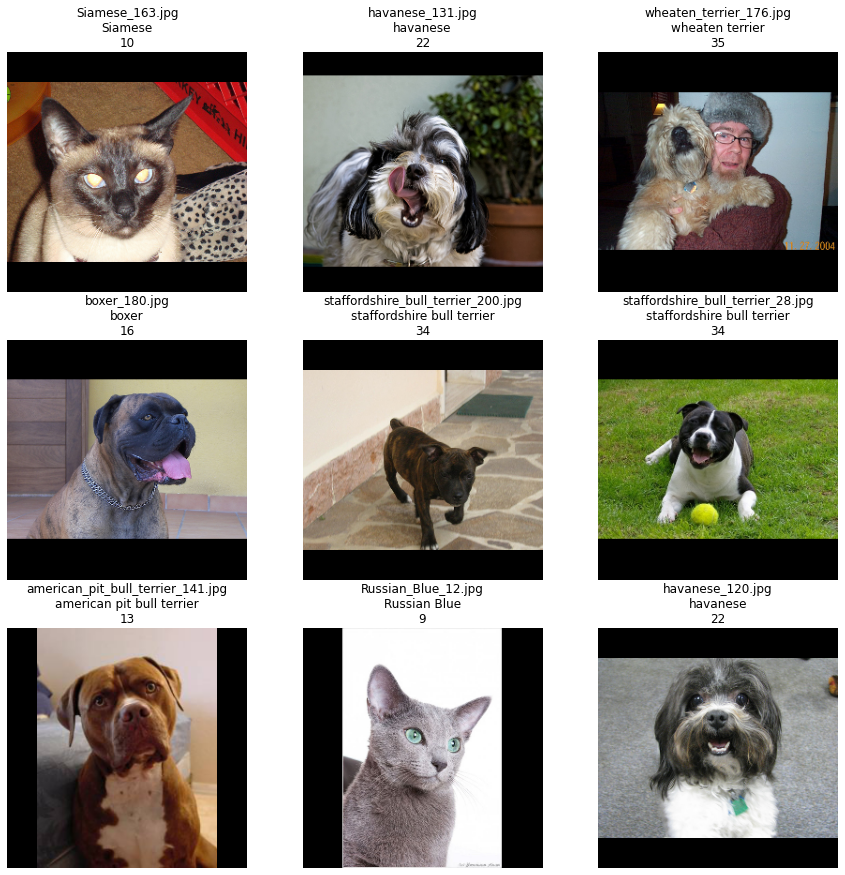

In [16]:
plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(imageNames), size = 9)):
  plt.subplot(3, 3, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f'{imageNames[imgIndex]}\n{labels[imgIndex]}\n{labelsEncoded[imgIndex]}')
  plt.imshow(imageData[imgIndex])
plt.show()

In [17]:
imageData.max()

255

In [18]:
X_tv, X_test, y_tv, y_test = train_test_split(
    imageData, 
    labelsEncoded, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = labelsEncoded
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_tv, 
    y_tv, 
    test_size = VAL_SIZE, 
    random_state = RANDOM_STATE, 
    stratify = y_tv
    )

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')

Training Data: (5985, 256, 256, 3)
Training Labels: 5985

Validation Data: (666, 256, 256, 3)
Validation Labels: 666

Testing Data: (739, 256, 256, 3)
Testing Labels: 739


In [19]:
del imageData
del labelsEncoded
del X_tv
del y_tv

In [20]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = X_train, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

188

In [21]:
val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = X_val, y = y_val, batch_size = BATCH_SIZE, shuffle = True)
len(val_data)

21

In [22]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = X_test, y = y_test, batch_size = BATCH_SIZE)
len(test_data)

24

In [23]:
def plot_generator_images(gen, suptitle, labelDecDict, print_pred = False, model = None, nrows = 3, ncols = 3, figsize = (12, 12)):
    gen_data = gen.next()
    
    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.suptitle(suptitle, fontsize = 20)
    plt.tight_layout(rect = [0, 0, 1, 0.96], h_pad = 2)
    
    if(print_pred and model):
        pred = np.argmax(model.predict(gen_data[0]), axis=1)

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis(False)
        plt.grid(False)
        
        if(print_pred and pred.any()):
            plt.title(f"True: {labelDecDict[gen_data[1][i]]}\nPredicted: {labelDecDict[pred[i]]}")
        else:
            plt.title(labelDecDict[gen_data[1][i]])
        plt.imshow(gen_data[0][i])

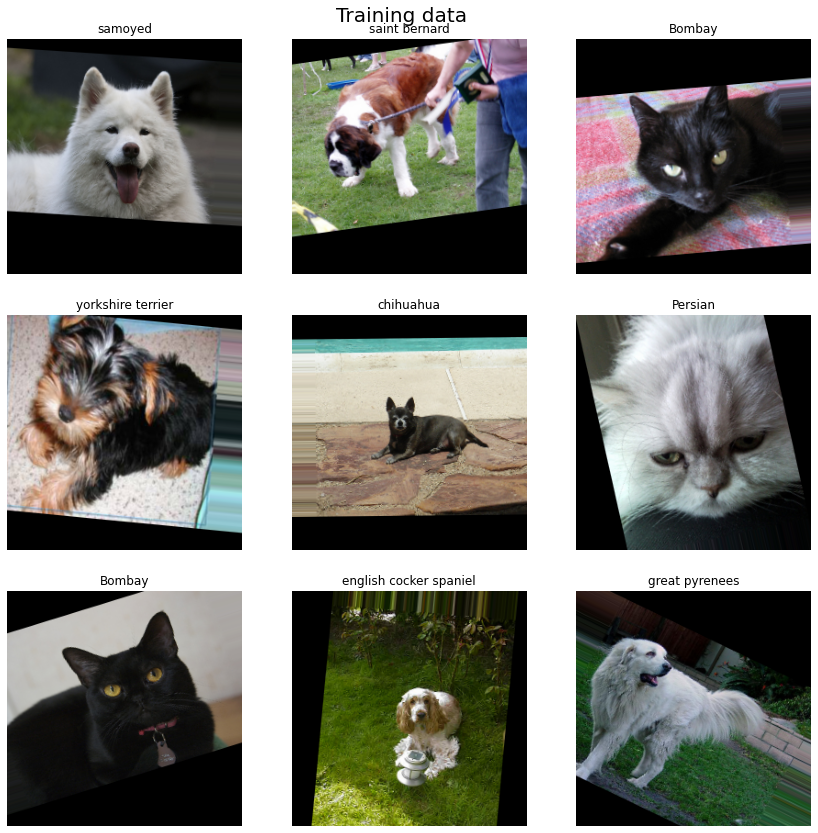

In [24]:
plot_generator_images(train_data, "Training data", labelDecDict)

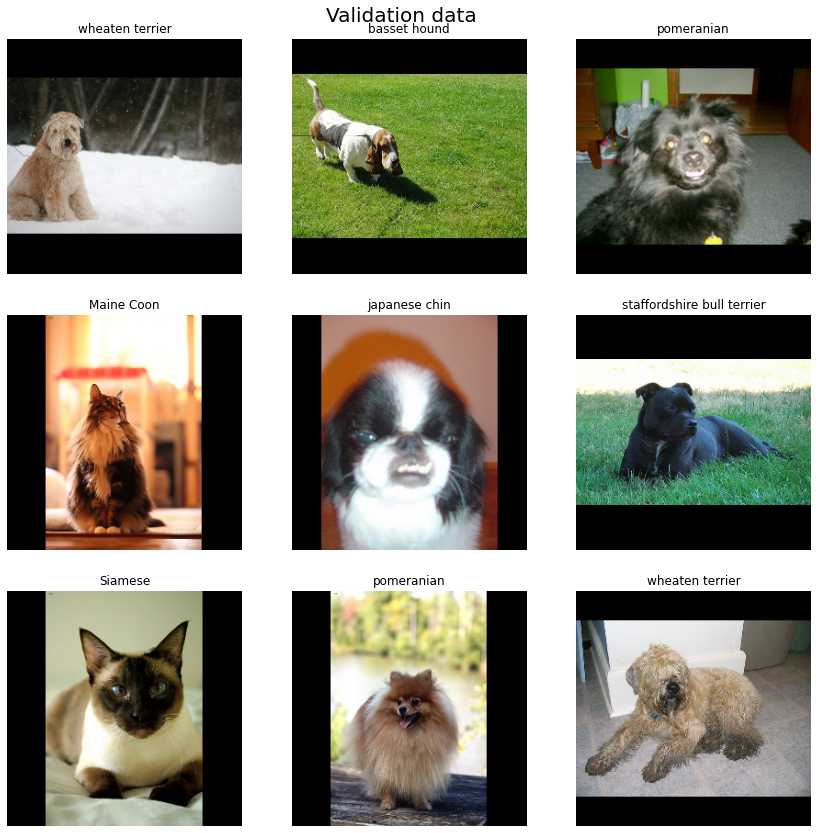

In [25]:
plot_generator_images(val_data, "Validation data", labelDecDict)

In [26]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(32, 4, padding = 'same'),
    Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same'),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, padding = 'same'),
    Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(128, 3, padding = 'same'),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(128, 2, padding = 'same'),
    Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(256, 2, padding = 'same'),
    Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    
    Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation = 'sigmoid'),
    Dropout(0.2),
    Dense(256, activation = 'sigmoid'),
    Dropout(0.1),
    Dense(len(labelEncDict), activation = 'softmax')
])

model.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                    

In [28]:
%%time

earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 20)

history = model.fit(train_data, validation_data = val_data, epochs = EPOCHS, verbose = 1, callbacks = [earlyStop, tensorBoard])

Epoch 1/35
188/188 [==============================] - 141s 749ms/step - loss: 3.6145 - sparse_categorical_accuracy: 0.0403 - val_loss: 3.6074 - val_sparse_categorical_accuracy: 0.0300
Epoch 2/35
188/188 [==============================] - 153s 812ms/step - loss: 3.4823 - sparse_categorical_accuracy: 0.0698 - val_loss: 3.4947 - val_sparse_categorical_accuracy: 0.0601
Epoch 3/35
188/188 [==============================] - 116s 614ms/step - loss: 3.3762 - sparse_categorical_accuracy: 0.0947 - val_loss: 3.3814 - val_sparse_categorical_accuracy: 0.1156
Epoch 4/35
188/188 [==============================] - 113s 602ms/step - loss: 3.2793 - sparse_categorical_accuracy: 0.1111 - val_loss: 3.2673 - val_sparse_categorical_accuracy: 0.1246
Epoch 5/35
188/188 [==============================] - 115s 609ms/step - loss: 3.1980 - sparse_categorical_accuracy: 0.1250 - val_loss: 3.1763 - val_sparse_categorical_accuracy: 0.1502
Epoch 6/35
188/188 [==============================] - 112s 593ms/step - loss: 3.

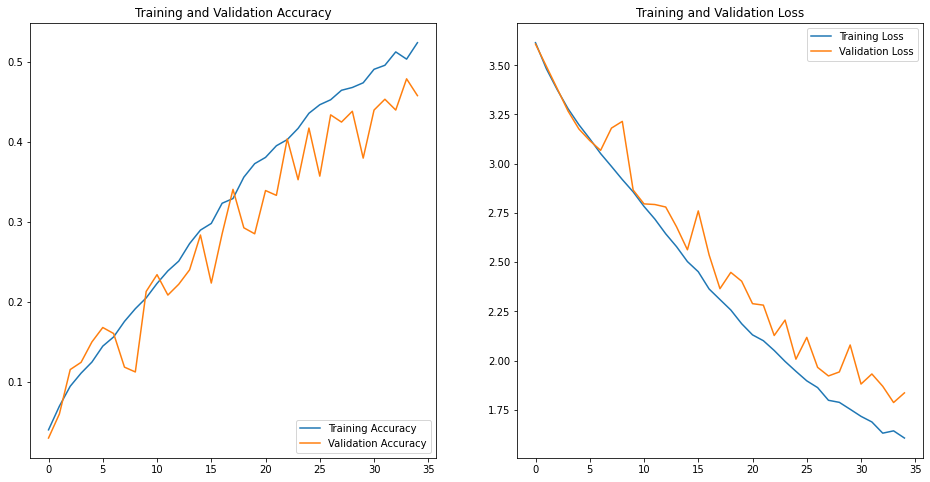

In [30]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

In [31]:
test_loss, test_acc = model.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {test_loss}")
print(f"Accuracy on Testing data: {test_acc}")

Loss on Testing data: 1.8057857751846313
Accuracy on Testing data: 0.46008118987083435


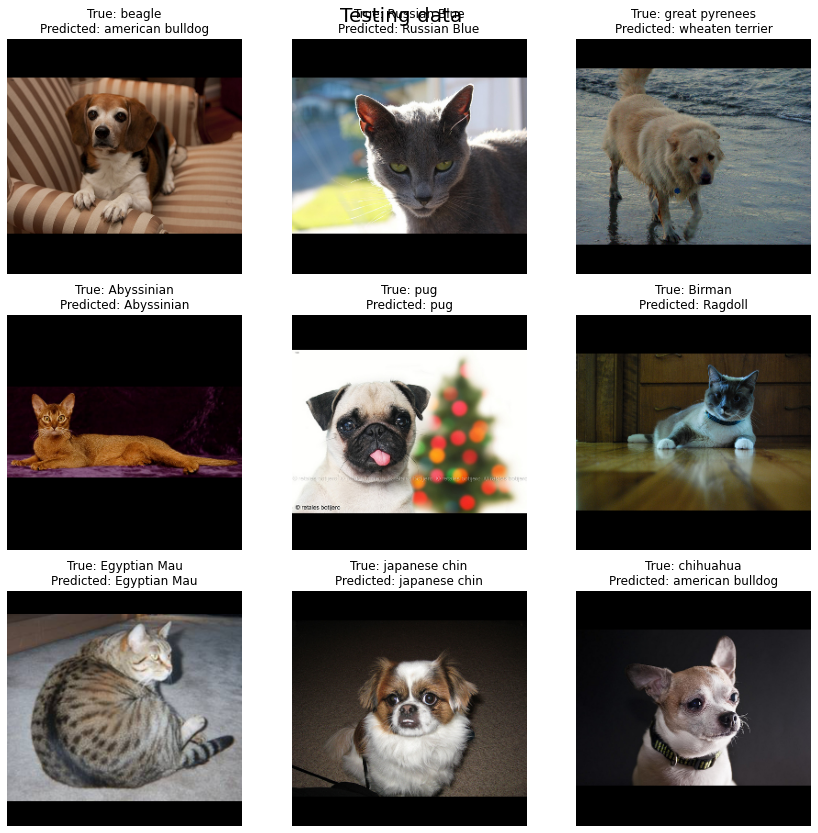

In [32]:
plot_generator_images(test_data, "Testing data", labelDecDict, print_pred = True, model = model)

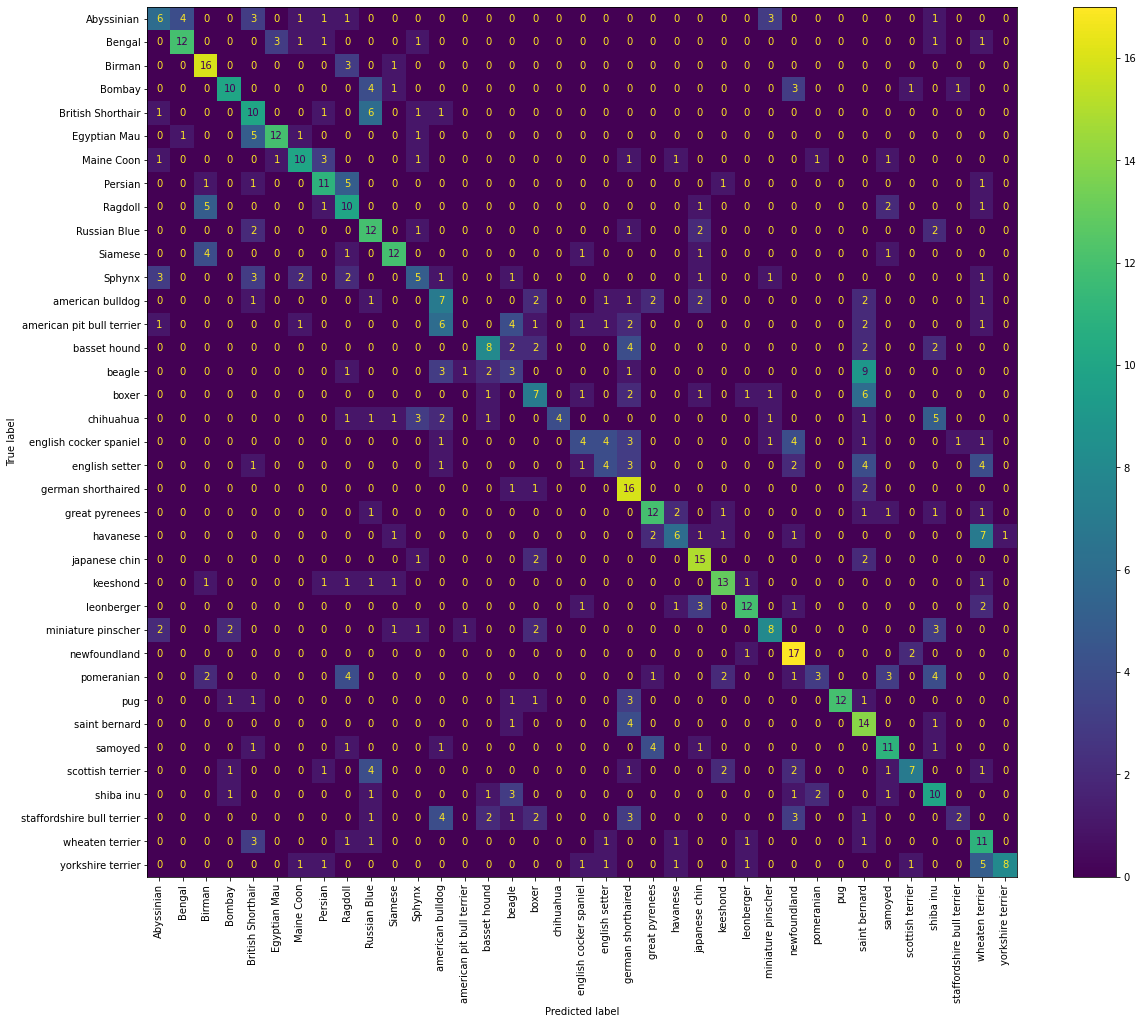

In [33]:
y_pred = np.argmax(model.predict(X_test/255), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = list(labelEncDict.values())),
                        display_labels = list(labelEncDict.keys())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

In [34]:
model.save('models/pet_image_classifier.h5')

In [35]:
saved_model = tf.keras.models.load_model('models/pet_image_classifier.h5')

sm_test_loss, sm_test_acc = saved_model.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {sm_test_loss}")
print(f"Accuracy on Testing data: {sm_test_acc}")

Loss on Testing data: 1.8057861328125
Accuracy on Testing data: 0.46008118987083435


### **LOCALIZATION**

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [41]:
def getBB(file):
  
  #parse the annotations
  path = f'annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = f'images/{file[:-4]}.jpg'
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

((170, 16), (248, 87))


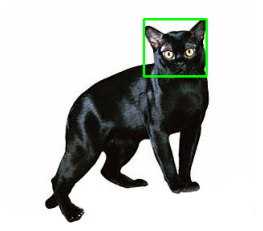

In [42]:
file = np.random.choice(os.listdir('annotations/xmls/'))
drawBB(file)

In [47]:
## Generator function - generates the batches of image with some processing
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        img_path = f'images/{f[:-4]}.jpg'
        img = Image.open(img_path)
        w,h = img.size
        
        img = img.resize(sz)
        (xmin, ymin), (xmax, ymax) = getBB(f)
        
        img = np.array(img).astype('float32')
        if len(img.shape) == 2:
          img = np.stack((img,)*3, axis=-1)

        else:
          img = img[:,:,0:3]
        
        box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])

        batch_x.append(img/255)
        batch_y.append(box)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y)      
    

In [48]:
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir('annotations/xmls/')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
train_generator = image_generator(train_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))
test_generator  = image_generator(test_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))


Size of training  3501
Size of testing   185


In [49]:
x, y = next(test_generator)

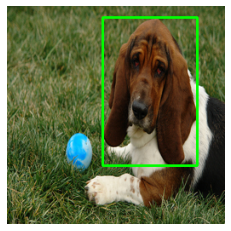

In [50]:
## Multiplying img to 255 becuase while creating generators divided by 255 for preprocessing image
## Here we need to display hence multiplyign again
img = (x[0] * 255).astype('uint8')

## box coordinates
box = y[0]
## multiplying coordinates by Image size becuase we took ratio while making generators
box = [int(IMG_SIZE *i) for i in box]

annotated = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.axis('off')
plt.imshow(annotated)

In [51]:
def iou(boxA, boxB):
  
  #evaluate the intersection points 
  xA = tf.maximum(boxA[:, 0], boxB[:, 0])
  yA = tf.maximum(boxA[:, 1], boxB[:, 1])

  xB = tf.minimum(boxA[:, 2], boxB[:, 2])
  yB = tf.minimum(boxA[:, 3], boxB[:, 3])

  a1 = tf.maximum(0.0, xB - xA + 1)
  a2 = tf.maximum(0.0, yB - yA + 1)
  # compute the area of intersection rectangle
  interArea = a1 * a2

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
  boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return tf.reduce_mean(interArea / unionArea)

In [53]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))
conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(inp)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(pool2)
pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(pool3)
pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(pool4)
pool5 = MaxPooling2D(pool_size = (2, 2))(conv5)

conv6 = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(pool5)
pool6 = MaxPooling2D(pool_size = (2, 2))(conv6)

flatten = Flatten()(pool6)
dense1 = Dense(128, activation = 'relu')(flatten)
drop1  = Dropout(0.5)(dense1)
out = Dense(4, activation = 'sigmoid')(drop1)

model = tf.keras.models.Model(inputs = inp, outputs = out)
model.compile(optimizer='adam' , loss = 'mean_squared_error', metrics = [iou])

print(inp)
#create a checkpoint for the best model 
# model_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou', mode='max', save_weights_only= True, verbose = 0)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [54]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps)
                    # ,callbacks=[model_save])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
109/109 [==============================] - 46s 392ms/step - loss: 0.0256 - iou: 0.7106 - val_loss: 0.0205 - val_iou: 0.7437
Epoch 2/30
109/109 [==============================] - 37s 344ms/step - loss: 0.0227 - iou: 0.7239 - val_loss: 0.0211 - val_iou: 0.7302
Epoch 3/30
109/109 [==============================] - 36s 333ms/step - loss: 0.0218 - iou: 0.7309 - val_loss: 0.0154 - val_iou: 0.7709
Epoch 4/30
109/109 [==============================] - 34s 316ms/step - loss: 0.0200 - iou: 0.7438 - val_loss: 0.0131 - val_iou: 0.7886
Epoch 5/30
109/109 [==============================] - 51s 468ms/step - loss: 0.0171 - iou: 0.7628 - val_loss: 0.0137 - val_iou: 0.7961
Epoch 6/30
109/109 [==============================] - 34s 310ms/step - loss: 0.0144 - iou: 0.7809 - val_loss: 0.0108 - val_iou: 0.8151
Epoch 7/30
109/109 [==============================] - 34s 312ms/step - loss: 0.0117 - iou: 0.8000 - val_loss: 0.0081 - val_iou: 0.8355
Epoch 8/30
109/109 [==============================] - 3

In [55]:
model.save('/content/localization_model/localisation.h5')

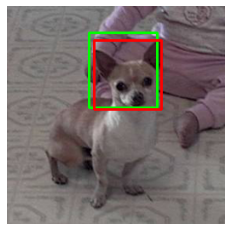

In [56]:
x,y = next(test_generator)
img = x[0]
box = model.predict(np.expand_dims(img, 0))[0]
box = [int(IMG_SIZE*i) for i in box]
annotated = cv2.rectangle((img*255) , (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
box = [int(IMG_SIZE * i) for i in y[0]]
annotated = cv2.rectangle((annotated) , (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.axis('off')
plt.imshow((annotated ).astype('uint8'))